# Use-Cases of TDA Usage on 3D Shapes

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import warnings, tqdm
warnings.simplefilter('ignore')

from mpl_toolkits.mplot3d import Axes3D

from filtration.filtration import *

pyo.init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


## ToolBox Functions

In [2]:
# The following function aims at loading the 3D point cloud from formatted files. 
# Those files contains different object, and filtering is necessary to extract what we are looking for.

def load_3D_shape(filepath):

    vec = []
    num = sum(1 for line in open(filepath, 'r'))

    with open(filepath, 'r') as raw:
        for idx in tqdm.tqdm(range(num)):
            tmp = raw.readline().split(' ')
            if len(tmp) == 3: vec.append(np.asarray(tmp).astype('float'))

    vec = np.vstack(vec)
    
    return vec

In [3]:
# This function build the corresponding simplex tree and filtration given the 3D point cloud.
# It is based on the gudhi.SimpleTree structure, and a robust neighboring graph.

def sublevels_3D(vec):    
    
    kdt = KDTree(vec[:,:], metric='euclidean')
    sxt = gudhi.SimplexTree()

    for ind in range(len(vec)):
        sxt.insert([ind], filtration=-vec[ind,2])
        nei = kdt.query([vec[ind,:]], 5, return_distance=False)[0][1:]
        for idx in nei:
            sxt.insert([ind, idx], filtration=np.mean([-vec[ind,2], -vec[idx,2]]))

    sxt.initialize_filtration()
    sxt.persistence()

    return sxt

In [4]:
# Given a filtrated simple tree, this function renders the betti curves in dimension 0.
# The dimension 0 is representative of the connected components (cycles would here be irrelevant).

def betti_curves(sxt):
    
    v = np.zeros(100)
    
    dig = sxt.persistence_intervals_in_dimension(0)
    dig = np.asarray([[ele[0], ele[1]] for ele in dig if ele[1] < np.inf])
    
    mnu, mxu = np.min(dig), np.max(dig)
    dis = np.linspace(mnu, mxu, num=100)
    
    for ele in dig: v += functionize(dis, ele)
        
    # The output will be a non-scaled betti curve discretized over 100 points
        
    return v

In [5]:
# Given a filtrated simple tree, this function renders the persistent landscapes in dimension 0.

def landscapes(sxt):
    
    dig = sxt.persistence_intervals_in_dimension(0)
    dig = np.asarray([[ele[0], ele[1]] for ele in dig if ele[1] < np.inf])
    
    # The output will be 10 non-scaled landscapes discretized over 100 points
    
    return build_landscapes(dig, 10, 100, None, None)

## Construction

In [6]:
vec = load_3D_shape('./samples/181.off')
sxt = sublevels_3D(vec)
# Extracts the components of dimension 0
dig = [(0, val) for val in sxt.persistence_intervals_in_dimension(0)]
btc = betti_curves(sxt)
ldc = landscapes(sxt)

100%|██████████| 21722/21722 [00:00<00:00, 333451.69it/s]


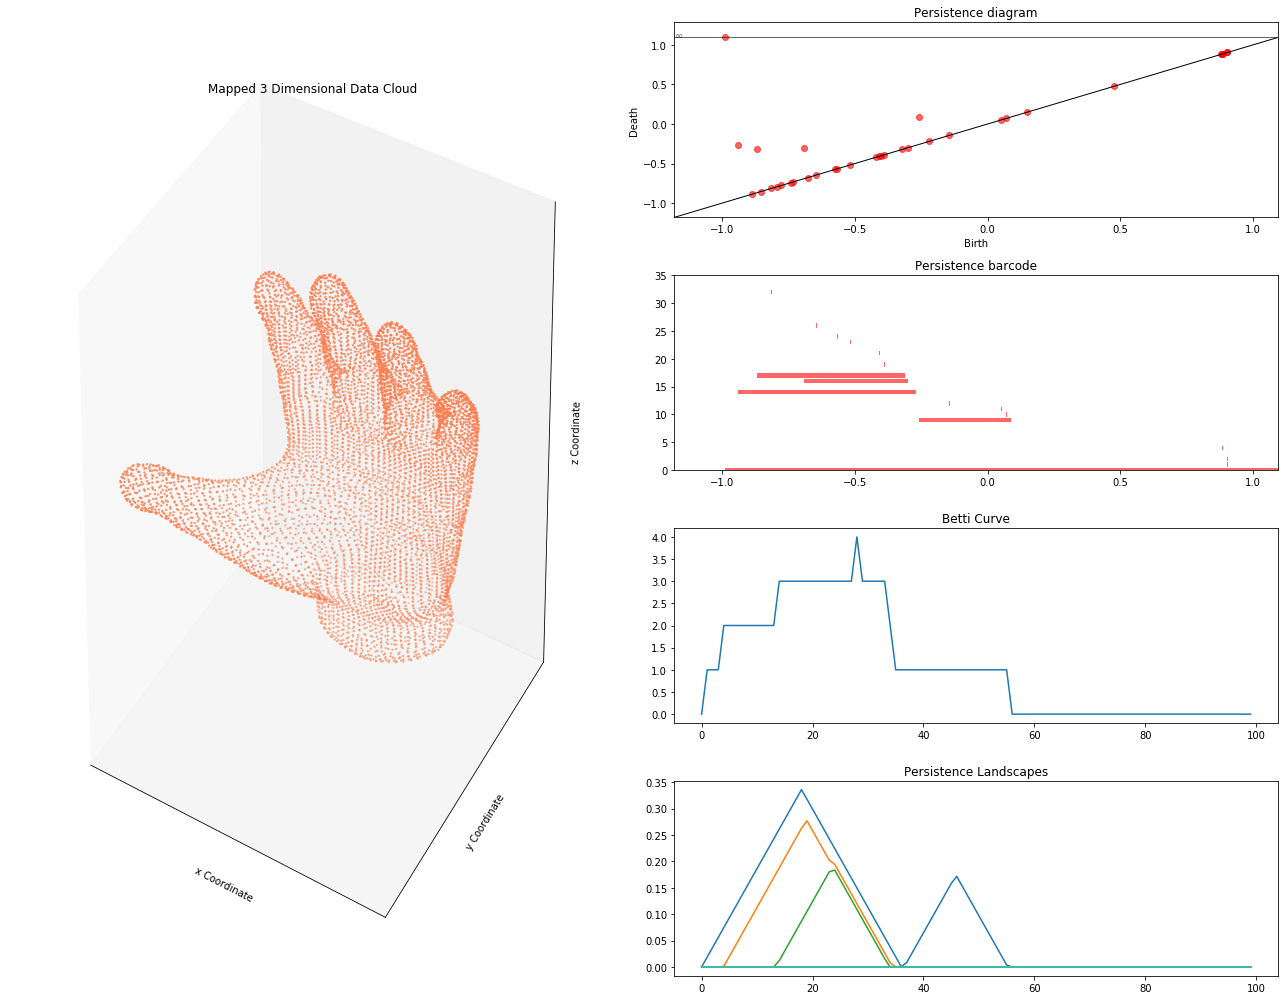

In [7]:
plt.figure(figsize=(18,14))
fig = gds.GridSpec(4, 2)
ax0 = plt.subplot(fig[:,0], projection='3d')
ax0.set_title('Mapped 3 Dimensional Data Cloud')
ax0.set_xticks([])                               
ax0.set_yticks([])                               
ax0.set_zticks([])
ax0.scatter(vec[:,0], vec[:,1], vec[:,2], s=2, c='coral')
ax0.set_xlabel('x Coordinate')
ax0.set_ylabel('y Coordinate')
ax0.set_zlabel('z Coordinate')
plt.subplot(fig[0,1])
gudhi.plot_persistence_diagram(dig)
plt.subplot(fig[1,1])
gudhi.plot_persistence_barcode(dig)
plt.subplot(fig[2,1])
plt.title('Betti Curve')
plt.plot(btc)
plt.subplot(fig[3,1])
plt.title('Persistence Landscapes')
for ele in ldc: plt.plot(ele)
plt.tight_layout()
plt.show()